# Research for finding Rolex
The problem described is a classification problem. This is why I've decided to use logistic regression. It is fast to train and provides good accuracy. In this document I will show why this is a good decision.

In [20]:
from os import listdir
from os.path import isfile, join
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import ShuffleSplit, train_test_split
from sklearn.learning_curve import learning_curve
from sklearn.grid_search import GridSearchCV
from scipy.ndimage import imread
from scipy.misc import imresize
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

## 1. Loading images
First we load images of logos and background from folders.

In [2]:
url = '/Users/tomasz.dobrzycki/find-rolex_local/train_dataset'
back_url = join(url, 'background')
logo_url = join(url, 'rolex')
back_files = [join(back_url, f) for f in listdir(back_url) if isfile(join(back_url, f)) and '.jpg' in f]
logo_files = [join(logo_url, f) for f in listdir(logo_url) if isfile(join(logo_url, f)) and '.jpg' in f]

## 2. Preprocessing
To process the images, we need to prepare them. After some experiments I decided that resizing images to 50x50 colour provides good results while reducing dimensionality.
Then images are flattened and labels are added.
Finally we split the data into training and test sets.

In [7]:
size = (50, 50, 3)
back_images = pd.DataFrame([imresize(imread(f), size).flatten() for f in back_files])
logo_images = pd.DataFrame([imresize(imread(f), size).flatten() for f in logo_files])

In [11]:
back_images['Logo'] = 0
logo_images['Logo'] = 1
org_data_set = back_images.append(logo_images)
X, y = org_data_set.ix[:, :'7499'], org_data_set['Logo']
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2)

## 3. Learning curves
To decide whether it's worth expanding the dataset I will plot learning curves. This shows how accuracy changes with increase of dataset.

In [24]:
cv = ShuffleSplit(X.shape[0], n_iter=10, test_size=0.2, random_state=0)

train_sizes, train_scores, test_scores = learning_curve(LogisticRegression(), X, y, cv=cv, n_jobs=4, 
                                                        train_sizes=np.linspace(.1, 1.0, 5))
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

It looks like there is not much improvement beyond 500 datapoints, so I will use the unexpanded set.

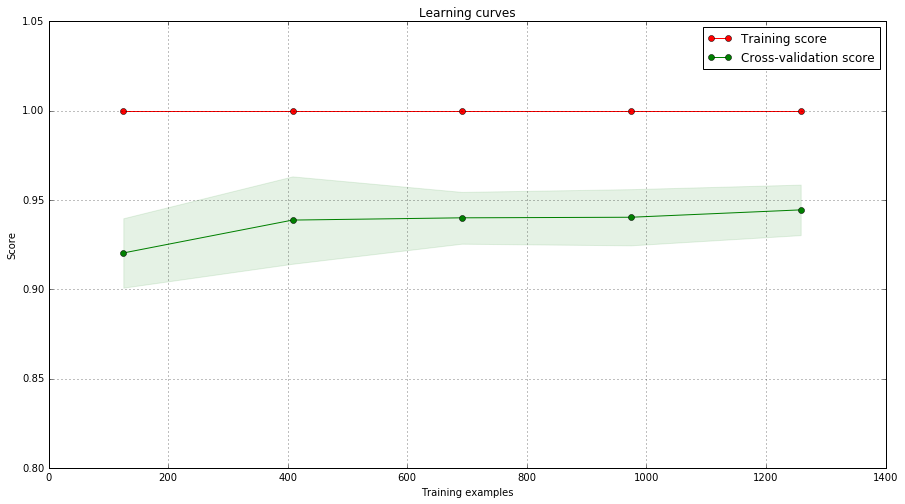

In [25]:
plt.figure(figsize=(15, 8))
plt.title('Learning curves')
plt.ylim([0.8, 1.05])
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.grid()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, 
                 color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.legend()
plt.show()

## 4. Tuning hyperparameters
Finally it's worth tuning hyperparameters - C in this case. C is the inverse of strength of regularisation. Low values of C would prevent the model from overfitting.

In [21]:
parameters = {'C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]}
grid = GridSearchCV(LogisticRegression(), param_grid=parameters)
grid.fit(X_train, Y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

The optimal value of C is 0.001 although the differences between searched values are not huge. We could as well use the default value.

In [23]:
print grid.grid_scores_
print grid.best_score_
print grid.best_params_

[mean: 0.93800, std: 0.01270, params: {'C': 0.001}, mean: 0.93084, std: 0.01078, params: {'C': 0.01}, mean: 0.92687, std: 0.00587, params: {'C': 0.1}, mean: 0.92687, std: 0.00587, params: {'C': 1.0}, mean: 0.92607, std: 0.00577, params: {'C': 10.0}, mean: 0.92766, std: 0.00676, params: {'C': 100.0}, mean: 0.92687, std: 0.00587, params: {'C': 1000.0}]
0.93799682035
{'C': 0.001}
